In [1]:

from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
import pandas as pd
import os


from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from datetime import datetime

from winn_dixie_recpt_parser import WinnDixieRecptParser 

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

print(os.getcwd())


C:\Users\steve\OneDrive - NOLA Business IT\source\repos\grocery-ml


In [2]:

rows = []

recptParser  = WinnDixieRecptParser();

for p in Path("StevePhone2/pdf/text").glob("*.txt"):
    result = recptParser.parse(p.read_text(encoding="utf-8", errors="ignore"))
    for r in result["items"]:
        rows.append({
            "source": p.name,
            "date": result["date"],
            "time": result["time"],
            "manager": result["manager"],
            "cashier": result["cashier"],
            "item": r["item"],
            "qty": r["qty"],
            "reg": r["reg"],
            "youPay": r["youPay"],
            "reportedItemsSold": result["reported"],
            #"rowsMatchReported": result["validation"]["rowsMatchReported"],
            "qtyMatchReported": result["validation"]["qtyMatchReported"],
        })

df = pd.DataFrame(rows)


# Multihot encoding

In [3]:
df["date"] = pd.to_datetime(df["date"])
df["time"] = df["time"].astype(str)

df = df.sort_values(["date", "time"])
df

,source,date,time,manager,cashier,item,qty,reg,youPay,reportedItemsSold,qtyMatchReported
761,IMG_9764.txt,2024-11-15,8:13 PM,None,STEPHEN,SpaghettiOs Pasta,2,3.18,2.50,8,True
762,IMG_9764.txt,2024-11-15,8:13 PM,None,STEPHEN,Mars Chocolate,1,6.49,6.49,8,True
763,IMG_9764.txt,2024-11-15,8:13 PM,None,STEPHEN,M&M's Candies,1,1.79,1.79,8,True
764,IMG_9764.txt,2024-11-15,8:13 PM,None,STEPHEN,Mandarins,1,6.99,5.99,8,True
765,IMG_9764.txt,2024-11-15,8:13 PM,None,STEPHEN,Sparkling Ice Wtr,1,1.29,1.00,8,True
...,...,...,...,...,...,...,...,...,...,...,...
11,IMG_9656.txt,2025-11-04,2:00 PM,PAUL,ACM LANE_73,Kleinpeter Milk,1,6.89,6.89,18,True
0,IMG_9655.txt,2025-11-05,5:59 PM,PAUL,STEPHEN,k&l Canned Beans,1,1.39,0.99,4,True
1,IMG_9655.txt,2025-11-05,5:59 PM,PAUL,STEPHEN,Blue Runner Beans,1,3.79,3.79,4,True
2,IMG_9655.txt,2025-11-05,5:59 PM,PAUL,STEPHEN,Manda Sausage,1,5.69,5.19,4,True


In [4]:
grouped = (
    df
    .groupby(["date", "time"])["item"]
    .apply(list)
    .reset_index()
)
#print(type(grouped["item"][0]))
#print(grouped["item"][0])

unique_items = set()
for item_list in grouped["item"]:
    for name in item_list:
        unique_items.add(name)
unique_items = sorted(unique_items)

item_to_index = {}
for i in range(len(unique_items)):
    item_to_index[unique_items[i]] = i

print(item_to_index)



{'15ct Oatmeal Raisi': 0, '18ct Variety Mix': 1, '4 Star Roast Beef': 2, '6ct Buttercream Cu': 3, 'A&H FRSH ESCP': 4, 'ALM PETIT FOUR': 5, 'APPLE JACK DONUT': 6, 'AXE BERGAMOT BODY': 7, 'Andes Snap Bar': 8, "Annie Chun's Bowl": 9, 'Arizona Tea': 10, 'Arm & Hammer Dtgnt': 11, 'Armour Crunchers': 12, 'Armour Meatballs': 13, 'Arrid Deodorant': 14, "Assume it's Butter": 15, 'BB MINI SWIRL CONE': 16, 'BE SF SLT PEPPR BR': 17, 'BE SF WINTER BLEND': 18, 'BHF Carrots': 19, 'BODYARMOR 160Z FRU': 20, 'Bacon Inst Grits': 21, 'Bagel Bites Chs &': 22, 'Beef Cubed Steak': 23, "Bernard's Hny Bear": 24, 'Betty Crcekr Potato': 25, 'Blue Bell IceCream': 26, 'Blue Plate Mayo': 27, 'Blue Plate Mynnase': 28, 'Blue Runner Beans': 29, 'BlueBonnet Margrne': 30, 'Body Armor Drink': 31, 'Bomb Pop Popsicles': 32, 'Boneless Pork Ribs': 33, "Bro's Nat Strawbs": 34, 'Broccoli Florets': 35, 'Bunny Bread': 36, "Bush's Best Beans": 37, 'Butterball Turkey': 38, 'CC Sparkling Water': 39, 'CELSIUS SPKLNG KIW': 40, 'CHOBA

In [5]:
num_items = len(unique_items)
vectors = []

for item_list in grouped["item"]:
    vector = np.zeros(num_items, dtype=np.int32)

    for name in item_list:
        index = item_to_index[name]
        vector[index] = 1

    vectors.append(vector)



encoded_df = pd.DataFrame(vectors, columns=unique_items)
encoded_df = pd.concat([grouped[["date", "time"]], encoded_df], axis=1)

encoded_df





,date,time,15ct Oatmeal Raisi,18ct Variety Mix,4 Star Roast Beef,6ct Buttercream Cu,A&H FRSH ESCP,ALM PETIT FOUR,APPLE JACK DONUT,AXE BERGAMOT BODY,Andes Snap Bar,Annie Chun's Bowl,Arizona Tea,Arm & Hammer Dtgnt,Armour Crunchers,Armour Meatballs,Arrid Deodorant,Assume it's Butter,BB MINI SWIRL CONE,BE SF SLT PEPPR BR,BE SF WINTER BLEND,BHF Carrots,BODYARMOR 160Z FRU,Bacon Inst Grits,Bagel Bites Chs &,Beef Cubed Steak,Bernard's Hny Bear,Betty Crcekr Potato,Blue Bell IceCream,Blue Plate Mayo,Blue Plate Mynnase,Blue Runner Beans,BlueBonnet Margrne,Body Armor Drink,Bomb Pop Popsicles,Boneless Pork Ribs,Bro's Nat Strawbs,Broccoli Florets,Bunny Bread,Bush's Best Beans,Butterball Turkey,CC Sparkling Water,CELSIUS SPKLNG KIW,CHOBANI YOGURT,Campbell's Soup,Cheetos,Cheez-It Crackers,Chek Root Beer,Chek Soda,Chicken Cutlet,Chicken Leg,Chicken Thigh,Chicken Thighs,Chips Ahoy Cookies,Chisesi Ham,Chix Breast Tender,Chobani Yogrt Flip,Chobani Yogurt,Chse Vrty Inst Grt,Cilantro,Cinnagraham Cereal,Coca Cola,Coca Cola Cola,CocaCola Soda,Cocoa Krispies Crl,Coffee Mate Creamr,Corn,Crab Leg Surimi,Cupcakes 6ct,D&W Cheese,D&W Salami,D&W Turkey,DIGIORNO PIZZA,DOLE SLCD STRWBRY,DR PEPPER 12PK,Daisy French Onion,Daisy Sour Cream,Danimals Smoothie,Degree Dry Spray,Dewafelbakkr Pncks,Diet Bargs Rt Beer,Dole Shred Lettuce,Doritos Trtlla Chp,Dr Pepper 2002,Dr. Pepper 12pk,Dr. Pepper Soda,Edwards Pies,Eggland's Best Egg,Essentials Cookies,Essentials Plates,FBRZ AIR OCEAN,FRIED CKN 8PC,Fairlife Milk,Fanta Soda,Fbrz Air Refresher,Folgers Coffee,Fresh Meats,Fresh Strawberries,Fritos Dip,GAIN LQ HEC OXI WD,GM WFFL TST CRNC,GREENS BOT,Gatorade Beverage,Gevalia Kaffe Kcup,Glico Bscuit Stick,Gold Peak Tea,Good2Grow 100% Jce,Gortons Fsh Fillet,Goya Milk,Green Bell Pepper,Ground Beef,Ground Beef Rnd,HALLMARK ITEM,HC Cafe Steamers,HS Regular Bacon,HSWT Thk Bacon,Hershey's Candy,Hershey's Syrup,Home Select Foil,Hubba Bubba Gum,Hugbi Pies,ITTIBITZ COOKE&CRM,Jimmy Dean Bacon,Jimmy Dean Sausage,K&L CF EGG DZN,K&L Canned Veggie,KELLOGG APL JCK GT,Kinder Joy Treat,Kleinpeter Milk,Knorr Rice Sides,Know & Love Milk,Kool Aid Drinks,Kraft Cheese,Kraft Mac & Cheese,Krustz Pancake Mix,LITTLE DEBBIE FOOT,LNF REMIX,Lght 'n Flffy Ndle,Lipton Soup Mix,Little Debbie Snck,Little Hug Drink,London Broil,Lotus Cookie Buttr,Lttl Debbie Donuts,Lunchables Snack,M&M's Candies,MAGAZINE,MILK STRW,MINI SS TONGS 2CT,MM PB Mini Shr Sz,MONSTER ULTRA FANT,MR SUSHI SHELF ITEM,MSG BROWNIE BC,Manda Sausage,Mandarins,Mars Chocolate,Maruchan Ramen Sup,Master of Mixes Mx,Mayfield IceCream,McCormick Ssng Mix,Mentos Mint,Mini Carnation,Mini Valentine 2 t,Minute Maid Drink,Minute Maid Drinks,Minute Maid Lmnade,Mission Chips,Mission Tortillas,Mix Melon Chunks,Mixed Grapes,NABISCO MINI VARTY,NYB Garlic Bread,Nissin Noodle Soup,Nissin SF F Kor ch,Nissin SF Hon Chkn,Noosa Yogurt,Nutella Snack Pack,Nutella Spread,OIKOS REMIX,OM BASICS HAM-AMER,OM BASICS TURKEY-A,ON THE BORDER DIP,OP PRODUCE DEPT KEY,OREO GLDN FRSH STK,Old EP Taco Kit,On The Border Chip,Oscar Mayer Lnchbl,Oui Yogurt,POWERADE 8PK,PSF Skillet Vgtbls,Pasta Roni Pasta,Pearl Millng Syrup,Peter Pan Crnch Pe,Peter Pan Pnt Bttr,Philadlph Crm Chse,Pillsbury Biscuits,Pork Chops,Pork Shoulder,Prairie Farm Milk,Pringles Chips,Produce Cucumbers,Puffs Tissues,Pure Life 6pk,Pwrde Sports Drink,QTY 3. DR PEPPER 12PK,QTY 3. Hugbi Pies,QTY 3. Sno-Balls To Go,QTY 3. Sparkling Ice Wtr,QTY 3. Yellow Corn,QoTY 3 CocaCola Soda,Quaker Instnt Grts,Quaker Rice Crisps,REDDI-WIP,Red Baron Pizza,Reese's Candy,Rght Grd Ddrnt,Ritz Crackers,Romaine Hearts,SARGENTO CHEESE,SB TRPL SHOT RICH,SE Grocers Bread,SE Grocers Broth,SE Grocers Buns,SE Grocers Cheese,SE Grocers Foil,SE Grocers Juice,SE Grocers Olives,SE Grocers Pasta,SE Grocers Peanuts,SE Grocers Pickles,SE Grocers Syrup,SEG 100% Juice,SEG Alfredo Sauce,SEG Aluminum Foil,SEG BOIL-N-BAG,SEG Bagel Bites,SEG Breadsticks,SEG Canned Fruit,SEG Croutons,SEG Cutlery,SEG Distilled Watr,SEG Eraser Pads,SEG Fruit Punch,SEG Fudge Bar,

In [6]:
# fix time date

encoded_df["dateTime"] = pd.to_datetime(
    encoded_df["date"].astype(str) + " " + encoded_df["time"].astype(str),
    errors="coerce"
)

encoded_df = encoded_df.drop(columns=["date", "time"])

dt = encoded_df["dateTime"]

encoded_df["year"]    = dt.dt.year
encoded_df["month"]   = dt.dt.month
encoded_df["day"]     = dt.dt.day
encoded_df["hour"]    = dt.dt.hour
encoded_df["minute"]  = dt.dt.minute
encoded_df["dow"]     = dt.dt.dayofweek
encoded_df["doy"]     = dt.dt.dayofyear
encoded_df["quarter"] = dt.dt.quarter


encoded_df["hour_sin"] = np.sin(2 * np.pi * encoded_df["hour"] / 24.0)
encoded_df["hour_cos"] = np.cos(2 * np.pi * encoded_df["hour"] / 24.0)

encoded_df["minute_sin"] = np.sin(2 * np.pi * encoded_df["minute"] / 60.0)
encoded_df["minute_cos"] = np.cos(2 * np.pi * encoded_df["minute"] / 60.0)

encoded_df["dow_sin"] = np.sin(2 * np.pi * encoded_df["dow"] / 7.0)
encoded_df["dow_cos"] = np.cos(2 * np.pi * encoded_df["dow"] / 7.0)
encoded_df["month_sin"] = np.sin(2 * np.pi * encoded_df["month"] / 12.0)
encoded_df["month_cos"] = np.cos(2 * np.pi * encoded_df["month"] / 12.0)

encoded_df["doy_sin"] = np.sin(2 * np.pi * encoded_df["doy"] / 365.0)
encoded_df["doy_cos"] = np.cos(2 * np.pi * encoded_df["doy"] / 365.0)

cols_to_drop = ["month", "hour", "minute", "dow", "doy"]
encoded_df = encoded_df.drop(columns=cols_to_drop)

encoded_df

C:\Users\steve\AppData\Local\Temp\ipykernel_1396\1002127710.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  encoded_df["dateTime"] = pd.to_datetime(


,15ct Oatmeal Raisi,18ct Variety Mix,4 Star Roast Beef,6ct Buttercream Cu,A&H FRSH ESCP,ALM PETIT FOUR,APPLE JACK DONUT,AXE BERGAMOT BODY,Andes Snap Bar,Annie Chun's Bowl,Arizona Tea,Arm & Hammer Dtgnt,Armour Crunchers,Armour Meatballs,Arrid Deodorant,Assume it's Butter,BB MINI SWIRL CONE,BE SF SLT PEPPR BR,BE SF WINTER BLEND,BHF Carrots,BODYARMOR 160Z FRU,Bacon Inst Grits,Bagel Bites Chs &,Beef Cubed Steak,Bernard's Hny Bear,Betty Crcekr Potato,Blue Bell IceCream,Blue Plate Mayo,Blue Plate Mynnase,Blue Runner Beans,BlueBonnet Margrne,Body Armor Drink,Bomb Pop Popsicles,Boneless Pork Ribs,Bro's Nat Strawbs,Broccoli Florets,Bunny Bread,Bush's Best Beans,Butterball Turkey,CC Sparkling Water,CELSIUS SPKLNG KIW,CHOBANI YOGURT,Campbell's Soup,Cheetos,Cheez-It Crackers,Chek Root Beer,Chek Soda,Chicken Cutlet,Chicken Leg,Chicken Thigh,Chicken Thighs,Chips Ahoy Cookies,Chisesi Ham,Chix Breast Tender,Chobani Yogrt Flip,Chobani Yogurt,Chse Vrty Inst Grt,Cilantro,Cinnagraham Cereal,Coca Cola,Coca Cola Cola,CocaCola Soda,Cocoa Krispies Crl,Coffee Mate Creamr,Corn,Crab Leg Surimi,Cupcakes 6ct,D&W Cheese,D&W Salami,D&W Turkey,DIGIORNO PIZZA,DOLE SLCD STRWBRY,DR PEPPER 12PK,Daisy French Onion,Daisy Sour Cream,Danimals Smoothie,Degree Dry Spray,Dewafelbakkr Pncks,Diet Bargs Rt Beer,Dole Shred Lettuce,Doritos Trtlla Chp,Dr Pepper 2002,Dr. Pepper 12pk,Dr. Pepper Soda,Edwards Pies,Eggland's Best Egg,Essentials Cookies,Essentials Plates,FBRZ AIR OCEAN,FRIED CKN 8PC,Fairlife Milk,Fanta Soda,Fbrz Air Refresher,Folgers Coffee,Fresh Meats,Fresh Strawberries,Fritos Dip,GAIN LQ HEC OXI WD,GM WFFL TST CRNC,GREENS BOT,Gatorade Beverage,Gevalia Kaffe Kcup,Glico Bscuit Stick,Gold Peak Tea,Good2Grow 100% Jce,Gortons Fsh Fillet,Goya Milk,Green Bell Pepper,Ground Beef,Ground Beef Rnd,HALLMARK ITEM,HC Cafe Steamers,HS Regular Bacon,HSWT Thk Bacon,Hershey's Candy,Hershey's Syrup,Home Select Foil,Hubba Bubba Gum,Hugbi Pies,ITTIBITZ COOKE&CRM,Jimmy Dean Bacon,Jimmy Dean Sausage,K&L CF EGG DZN,K&L Canned Veggie,KELLOGG APL JCK GT,Kinder Joy Treat,Kleinpeter Milk,Knorr Rice Sides,Know & Love Milk,Kool Aid Drinks,Kraft Cheese,Kraft Mac & Cheese,Krustz Pancake Mix,LITTLE DEBBIE FOOT,LNF REMIX,Lght 'n Flffy Ndle,Lipton Soup Mix,Little Debbie Snck,Little Hug Drink,London Broil,Lotus Cookie Buttr,Lttl Debbie Donuts,Lunchables Snack,M&M's Candies,MAGAZINE,MILK STRW,MINI SS TONGS 2CT,MM PB Mini Shr Sz,MONSTER ULTRA FANT,MR SUSHI SHELF ITEM,MSG BROWNIE BC,Manda Sausage,Mandarins,Mars Chocolate,Maruchan Ramen Sup,Master of Mixes Mx,Mayfield IceCream,McCormick Ssng Mix,Mentos Mint,Mini Carnation,Mini Valentine 2 t,Minute Maid Drink,Minute Maid Drinks,Minute Maid Lmnade,Mission Chips,Mission Tortillas,Mix Melon Chunks,Mixed Grapes,NABISCO MINI VARTY,NYB Garlic Bread,Nissin Noodle Soup,Nissin SF F Kor ch,Nissin SF Hon Chkn,Noosa Yogurt,Nutella Snack Pack,Nutella Spread,OIKOS REMIX,OM BASICS HAM-AMER,OM BASICS TURKEY-A,ON THE BORDER DIP,OP PRODUCE DEPT KEY,OREO GLDN FRSH STK,Old EP Taco Kit,On The Border Chip,Oscar Mayer Lnchbl,Oui Yogurt,POWERADE 8PK,PSF Skillet Vgtbls,Pasta Roni Pasta,Pearl Millng Syrup,Peter Pan Crnch Pe,Peter Pan Pnt Bttr,Philadlph Crm Chse,Pillsbury Biscuits,Pork Chops,Pork Shoulder,Prairie Farm Milk,Pringles Chips,Produce Cucumbers,Puffs Tissues,Pure Life 6pk,Pwrde Sports Drink,QTY 3. DR PEPPER 12PK,QTY 3. Hugbi Pies,QTY 3. Sno-Balls To Go,QTY 3. Sparkling Ice Wtr,QTY 3. Yellow Corn,QoTY 3 CocaCola Soda,Quaker Instnt Grts,Quaker Rice Crisps,REDDI-WIP,Red Baron Pizza,Reese's Candy,Rght Grd Ddrnt,Ritz Crackers,Romaine Hearts,SARGENTO CHEESE,SB TRPL SHOT RICH,SE Grocers Bread,SE Grocers Broth,SE Grocers Buns,SE Grocers Cheese,SE Grocers Foil,SE Grocers Juice,SE Grocers Olives,SE Grocers Pasta,SE Grocers Peanuts,SE Grocers Pickles,SE Grocers Syrup,SEG 100% Juice,SEG Alfredo Sauce,SEG Aluminum Foil,SEG BOIL-N-BAG,SEG Bagel Bites,SEG Breadsticks,SEG Canned Fruit,SEG Croutons,SEG Cutlery,SEG Distilled Watr,SEG Eraser Pads,SEG Fruit Punch,SEG Fudge Bar,SEG Grape 

In [7]:

noncyc_cols = ["year", "day", "quarter"]

for col in noncyc_cols:
    mean = encoded_df[col].mean()
    std = encoded_df[col].std()

    if std == 0:
        std = 1.0

    encoded_df[col + "_norm"] = (encoded_df[col] - mean) / std

encoded_df = encoded_df.drop(columns=["year", "day", "quarter"])
encoded_df = encoded_df.drop(columns=["dateTime"])
encoded_df


,15ct Oatmeal Raisi,18ct Variety Mix,4 Star Roast Beef,6ct Buttercream Cu,A&H FRSH ESCP,ALM PETIT FOUR,APPLE JACK DONUT,AXE BERGAMOT BODY,Andes Snap Bar,Annie Chun's Bowl,Arizona Tea,Arm & Hammer Dtgnt,Armour Crunchers,Armour Meatballs,Arrid Deodorant,Assume it's Butter,BB MINI SWIRL CONE,BE SF SLT PEPPR BR,BE SF WINTER BLEND,BHF Carrots,BODYARMOR 160Z FRU,Bacon Inst Grits,Bagel Bites Chs &,Beef Cubed Steak,Bernard's Hny Bear,Betty Crcekr Potato,Blue Bell IceCream,Blue Plate Mayo,Blue Plate Mynnase,Blue Runner Beans,BlueBonnet Margrne,Body Armor Drink,Bomb Pop Popsicles,Boneless Pork Ribs,Bro's Nat Strawbs,Broccoli Florets,Bunny Bread,Bush's Best Beans,Butterball Turkey,CC Sparkling Water,CELSIUS SPKLNG KIW,CHOBANI YOGURT,Campbell's Soup,Cheetos,Cheez-It Crackers,Chek Root Beer,Chek Soda,Chicken Cutlet,Chicken Leg,Chicken Thigh,Chicken Thighs,Chips Ahoy Cookies,Chisesi Ham,Chix Breast Tender,Chobani Yogrt Flip,Chobani Yogurt,Chse Vrty Inst Grt,Cilantro,Cinnagraham Cereal,Coca Cola,Coca Cola Cola,CocaCola Soda,Cocoa Krispies Crl,Coffee Mate Creamr,Corn,Crab Leg Surimi,Cupcakes 6ct,D&W Cheese,D&W Salami,D&W Turkey,DIGIORNO PIZZA,DOLE SLCD STRWBRY,DR PEPPER 12PK,Daisy French Onion,Daisy Sour Cream,Danimals Smoothie,Degree Dry Spray,Dewafelbakkr Pncks,Diet Bargs Rt Beer,Dole Shred Lettuce,Doritos Trtlla Chp,Dr Pepper 2002,Dr. Pepper 12pk,Dr. Pepper Soda,Edwards Pies,Eggland's Best Egg,Essentials Cookies,Essentials Plates,FBRZ AIR OCEAN,FRIED CKN 8PC,Fairlife Milk,Fanta Soda,Fbrz Air Refresher,Folgers Coffee,Fresh Meats,Fresh Strawberries,Fritos Dip,GAIN LQ HEC OXI WD,GM WFFL TST CRNC,GREENS BOT,Gatorade Beverage,Gevalia Kaffe Kcup,Glico Bscuit Stick,Gold Peak Tea,Good2Grow 100% Jce,Gortons Fsh Fillet,Goya Milk,Green Bell Pepper,Ground Beef,Ground Beef Rnd,HALLMARK ITEM,HC Cafe Steamers,HS Regular Bacon,HSWT Thk Bacon,Hershey's Candy,Hershey's Syrup,Home Select Foil,Hubba Bubba Gum,Hugbi Pies,ITTIBITZ COOKE&CRM,Jimmy Dean Bacon,Jimmy Dean Sausage,K&L CF EGG DZN,K&L Canned Veggie,KELLOGG APL JCK GT,Kinder Joy Treat,Kleinpeter Milk,Knorr Rice Sides,Know & Love Milk,Kool Aid Drinks,Kraft Cheese,Kraft Mac & Cheese,Krustz Pancake Mix,LITTLE DEBBIE FOOT,LNF REMIX,Lght 'n Flffy Ndle,Lipton Soup Mix,Little Debbie Snck,Little Hug Drink,London Broil,Lotus Cookie Buttr,Lttl Debbie Donuts,Lunchables Snack,M&M's Candies,MAGAZINE,MILK STRW,MINI SS TONGS 2CT,MM PB Mini Shr Sz,MONSTER ULTRA FANT,MR SUSHI SHELF ITEM,MSG BROWNIE BC,Manda Sausage,Mandarins,Mars Chocolate,Maruchan Ramen Sup,Master of Mixes Mx,Mayfield IceCream,McCormick Ssng Mix,Mentos Mint,Mini Carnation,Mini Valentine 2 t,Minute Maid Drink,Minute Maid Drinks,Minute Maid Lmnade,Mission Chips,Mission Tortillas,Mix Melon Chunks,Mixed Grapes,NABISCO MINI VARTY,NYB Garlic Bread,Nissin Noodle Soup,Nissin SF F Kor ch,Nissin SF Hon Chkn,Noosa Yogurt,Nutella Snack Pack,Nutella Spread,OIKOS REMIX,OM BASICS HAM-AMER,OM BASICS TURKEY-A,ON THE BORDER DIP,OP PRODUCE DEPT KEY,OREO GLDN FRSH STK,Old EP Taco Kit,On The Border Chip,Oscar Mayer Lnchbl,Oui Yogurt,POWERADE 8PK,PSF Skillet Vgtbls,Pasta Roni Pasta,Pearl Millng Syrup,Peter Pan Crnch Pe,Peter Pan Pnt Bttr,Philadlph Crm Chse,Pillsbury Biscuits,Pork Chops,Pork Shoulder,Prairie Farm Milk,Pringles Chips,Produce Cucumbers,Puffs Tissues,Pure Life 6pk,Pwrde Sports Drink,QTY 3. DR PEPPER 12PK,QTY 3. Hugbi Pies,QTY 3. Sno-Balls To Go,QTY 3. Sparkling Ice Wtr,QTY 3. Yellow Corn,QoTY 3 CocaCola Soda,Quaker Instnt Grts,Quaker Rice Crisps,REDDI-WIP,Red Baron Pizza,Reese's Candy,Rght Grd Ddrnt,Ritz Crackers,Romaine Hearts,SARGENTO CHEESE,SB TRPL SHOT RICH,SE Grocers Bread,SE Grocers Broth,SE Grocers Buns,SE Grocers Cheese,SE Grocers Foil,SE Grocers Juice,SE Grocers Olives,SE Grocers Pasta,SE Grocers Peanuts,SE Grocers Pickles,SE Grocers Syrup,SEG 100% Juice,SEG Alfredo Sauce,SEG Aluminum Foil,SEG BOIL-N-BAG,SEG Bagel Bites,SEG Breadsticks,SEG Canned Fruit,SEG Croutons,SEG Cutlery,SEG Distilled Watr,SEG Eraser Pads,SEG Fruit Punch,SEG Fudge Bar,SEG Grape 

# TRAIN !!!

In [8]:
time_feature_cols = [
    "hour_sin", "hour_cos",
    "minute_sin", "minute_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "doy_sin", "doy_cos",
    "year_norm", "day_norm", "quarter_norm",
]

exclude = set(time_feature_cols + ["date", "time", "dateTime"])  # whatever time/meta cols still exist
item_cols = [c for c in encoded_df.columns if c not in exclude]

X = encoded_df[time_feature_cols].to_numpy(dtype=np.float32)   # shape: (num_trips, num_time_features)
y = encoded_df[item_cols].to_numpy(dtype=np.float32)          # shape: (num_trips, num_items)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test set
    random_state=42,
    shuffle=True
)

In [12]:
import sys
print(sys.executable)

import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_train.shape[1]     # number of time features (≈ 13)
output_dim = y_train.shape[1]    # number of items

model = models.Sequential([
    layers.Input(shape=(input_dim,)),

    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),

    layers.Dense(output_dim, activation="sigmoid")  # multi-label
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

C:\Users\steve\.conda\envs\intercard-ml\python.exe
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.0000e+00 - loss: 0.6942 - val_accuracy: 0.0000e+00 - val_loss: 0.6851
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.6807 - val_accuracy: 0.0000e+00 - val_loss: 0.6712
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.6664 - val_accuracy: 0.0000e+00 - val_loss: 0.6554
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.6497 - val_accuracy: 0.0000e+00 - val_loss: 0.6363
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.6296 - val_accuracy: 0.0000e+00 - val_loss: 0.6130
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.6050 - val_accuracy: 0.0000e+00 - val_loss: 0.5845
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.5747 - val_accuracy: 0.0000e+00 - val_loss: 0.5504
Epoch 8/20
3/3 ━━━

# DF CHECK

In [ ]:
# Read CSV
df_check = pd.read_csv("ListCheck.csv")
df_check.columns = df_check.columns.str.strip().str.lower()

df_check


In [7]:
df_check["datetime"] = pd.to_datetime(df_check["datetime"], errors="coerce")

C:\Users\steve\AppData\Local\Temp\ipykernel_13852\1989889571.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_check["datetime"] = pd.to_datetime(df_check["datetime"], errors="coerce")


In [8]:
df_check["cost"] = df_check["cost"].astype(str).str.replace(r"[\$,]", "", regex=True).astype(float)
df_check["itemcount"] = df_check["itemcount"].astype(str).str.extract(r"(\d+)").astype(int)
                                                                        
df_check = df_check.drop(columns="Location", errors="ignore")

# Compare with df_train trips by datetime and item count
missing = df_check[~df_check["datetime"].isin(df["dateTime"])]

missing

,datetime,location,cost,itemcount
15,2025-10-07 18:05:00,Winn-Dixie 2104 Williams Blvd,37.94,10
18,2025-09-28 17:02:00,Winn-Dixie 2104 Williams Blvd,63.15,21
21,2025-09-21 15:11:00,Winn-Dixie 2104 Williams Blvd,80.21,27
32,2025-08-25 19:11:00,Winn-Dixie 2104 Williams Blvd,95.20,25
41,2025-08-06 15:54:00,Winn-Dixie 2104 Williams Blvd,81.26,25
47,2025-07-24 14:47:00,Winn-Dixie 2104 Williams Blvd,84.64,25
54,2025-07-06 19:26:00,Winn-Dixie 2104 Williams Blvd,73.52,27
59,2025-06-14 18:03:00,Winn-Dixie 2104 Williams Blvd,161.20,35
60,2025-06-14 18:01:00,Winn-Dixie 2104 Williams Blvd,22.12,3
62,2025-06-08 20:18:00,Winn-Dixie 2104 Williams Blvd,108.31,25


In [9]:

df["totalTripSpend"] = df["totalTripSpend"].astype(float)

# merge for comparison
merged = pd.merge(
    df_check,
    df[["dateTime", "totalTripSpend"]],
    how="left",
    left_on="datetime",
    right_on="dateTime",
    indicator=True
)

# find rows missing or with cost mismatch
missing = merged[merged["_merge"] == "left_only"]
mismatch = merged[abs(merged["cost"] - merged["totalTripSpend"]) > 0.01]


,datetime,location,cost,itemcount,dateTime,totalTripSpend,_merge
0,2025-11-05 17:59:00,Winn-Dixie 2104 Williams Blvd,12.59,4,2025-11-05 17:59:00,12.16,both
1,2025-11-05 17:59:00,Winn-Dixie 2104 Williams Blvd,12.59,4,2025-11-05 17:59:00,12.16,both
2,2025-11-05 17:59:00,Winn-Dixie 2104 Williams Blvd,12.59,4,2025-11-05 17:59:00,12.16,both
3,2025-11-05 17:59:00,Winn-Dixie 2104 Williams Blvd,12.59,4,2025-11-05 17:59:00,12.16,both
4,2025-11-04 14:00:00,Winn-Dixie 2104 Williams Blvd,106.36,18,2025-11-04 14:00:00,102.76,both
...,...,...,...,...,...,...,...
809,2024-11-15 20:13:00,Winn-Dixie 2104 Williams Blvd,22.00,8,2024-11-15 20:13:00,21.26,both
810,2024-11-15 20:13:00,Winn-Dixie 2104 Williams Blvd,22.00,8,2024-11-15 20:13:00,21.26,both
811,2024-11-15 20:13:00,Winn-Dixie 2104 Williams Blvd,22.00,8,2024-11-15 20:13:00,21.26,both
812,2024-11-15 20:13:00,Winn-Dixie 2104 Williams Blvd,22.00,8,2024-11-15 20:13:00,21.26,both


# DF TRAIN

In [10]:
df_train = df.copy()



,source,manager,cashier,item,qty,reg,youPay,reportedItemsSold,qtyMatchReported,dateTime,year,month,day,hour,minute,dow,doy,quarter,discount,totalDiscountPerTrip,totalTripSpend
0,IMG_9655.txt,PAUL,STEPHEN,k&l Canned Beans,1,1.39,0.99,4,True,2025-11-05 17:59:00,2025,11,5,17,59,2,309,4,0.40,0.90,12.16
1,IMG_9655.txt,PAUL,STEPHEN,Blue Runner Beans,1,3.79,3.79,4,True,2025-11-05 17:59:00,2025,11,5,17,59,2,309,4,0.00,0.90,12.16
2,IMG_9655.txt,PAUL,STEPHEN,Manda Sausage,1,5.69,5.19,4,True,2025-11-05 17:59:00,2025,11,5,17,59,2,309,4,0.50,0.90,12.16
3,IMG_9655.txt,PAUL,STEPHEN,SEG BOIL-N-BAG,1,2.19,2.19,4,True,2025-11-05 17:59:00,2025,11,5,17,59,2,309,4,0.00,0.90,12.16
4,IMG_9656.txt,PAUL,ACM LANE_73,Hugbi Pies,2,5.38,5.38,18,True,2025-11-04 14:00:00,2025,11,4,14,0,1,308,4,0.00,52.01,102.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,IMG_9764.txt,None,STEPHEN,M&M's Candies,1,1.79,1.79,8,True,2024-11-15 20:13:00,2024,11,15,20,13,4,320,4,0.00,2.26,21.26
764,IMG_9764.txt,None,STEPHEN,Mandarins,1,6.99,5.99,8,True,2024-11-15 20:13:00,2024,11,15,20,13,4,320,4,1.00,2.26,21.26
765,IMG_9764.txt,None,STEPHEN,Sparkling Ice Wtr,1,1.29,1.00,8,True,2024-11-15 20:13:00,2024,11,15,20,13,4,320,4,0.29,2.26,21.26
766,IMG_9764.txt,None,STEPHEN,Sparkling Ice Wtr,1,1.29,1.00,8,True,2024-11-15 20:13:00,2024,11,15,20,13,4,320,4,0.29,2.26,21.26


In [11]:
# assume df_train already has year, month, day, hour, minute, dow, doy, quarter
df_train["hour_sin"] = np.sin(2 * np.pi * df_train["hour"] / 24)
df_train["hour_cos"] = np.cos(2 * np.pi * df_train["hour"] / 24)

df_train["minute_sin"] = np.sin(2 * np.pi * df_train["minute"] / 60)
df_train["minute_cos"] = np.cos(2 * np.pi * df_train["minute"] / 60)

df_train["dow_sin"] = np.sin(2 * np.pi * df_train["dow"] / 7)
df_train["dow_cos"] = np.cos(2 * np.pi * df_train["dow"] / 7)

df_train["month_sin"] = np.sin(2 * np.pi * df_train["month"] / 12)
df_train["month_cos"] = np.cos(2 * np.pi * df_train["month"] / 12)

df_train["doy_sin"] = np.sin(2 * np.pi * df_train["doy"] / 365)
df_train["doy_cos"] = np.cos(2 * np.pi * df_train["doy"] / 365)

df_train["quarter_sin"] = np.sin(2 * np.pi * df_train["quarter"] / 4)
df_train["quarter_cos"] = np.cos(2 * np.pi * df_train["quarter"] / 4)

df_train = df_train.drop(columns=["year", "month", "day", "hour", "minute", "dow", "doy", "quarter"])

In [12]:

scaler_reg = StandardScaler()
df_train["regScaled"] = scaler_reg.fit_transform(df_train[["reg"]].fillna(0.0))
df_train = df_train.drop(columns="reg", errors="ignore")

scaler_youPay = StandardScaler()
df_train["youPayScaled"] = scaler_youPay.fit_transform(df_train[["youPay"]].fillna(0.0))
df_train = df_train.drop(columns="youPay", errors="ignore")

scaler_discount = StandardScaler()
df_train["discountScaled"] = scaler_discount.fit_transform(df_train[["discount"]].fillna(0.0))
df_train = df_train.drop(columns="discount", errors="ignore")

scaler_totalDiscountPerTrip = StandardScaler()
df_train["totalDiscountPerTripScaled"] = scaler_totalDiscountPerTrip.fit_transform(df_train[["totalDiscountPerTrip"]].fillna(0.0))
df_train = df_train.drop(columns="totalDiscountPerTrip", errors="ignore")

scaler_totalTripSpend = StandardScaler()
df_train["totalTripSpendScaled"] = scaler_totalTripSpend.fit_transform(df_train[["totalTripSpend"]].fillna(0.0))
df_train = df_train.drop(columns="totalTripSpend", errors="ignore")

scaler_reported = StandardScaler()
df_train["reportedItemsSoldScaled"] = scaler_reported.fit_transform(df_train[["reportedItemsSold"]].fillna(0.0))
df_train = df_train.drop(columns="reportedItemsSold", errors="ignore")


,source,manager,cashier,item,qty,qtyMatchReported,dateTime,hour_sin,hour_cos,minute_sin,minute_cos,dow_sin,dow_cos,month_sin,month_cos,doy_sin,doy_cos,quarter_sin,quarter_cos,regScaled,youPayScaled,discountScaled,totalDiscountPerTripScaled,totalTripSpendScaled,reportedItemsSoldScaled
0,IMG_9655.txt,PAUL,STEPHEN,k&l Canned Beans,1,True,2025-11-05 17:59:00,-0.965926,-0.258819,-0.104528,0.994522,0.974928,-0.222521,-0.5,0.866025,-0.821477,0.570242,-2.449294e-16,1.0,-0.509282,-0.651729,-0.235017,-0.905595,-1.468750,-1.470757
1,IMG_9655.txt,PAUL,STEPHEN,Blue Runner Beans,1,True,2025-11-05 17:59:00,-0.965926,-0.258819,-0.104528,0.994522,0.974928,-0.222521,-0.5,0.866025,-0.821477,0.570242,-2.449294e-16,1.0,-0.275198,-0.223335,-0.332757,-0.905595,-1.468750,-1.470757
2,IMG_9655.txt,PAUL,STEPHEN,Manda Sausage,1,True,2025-11-05 17:59:00,-0.965926,-0.258819,-0.104528,0.994522,0.974928,-0.222521,-0.5,0.866025,-0.821477,0.570242,-2.449294e-16,1.0,-0.089882,-0.009138,-0.210582,-0.905595,-1.468750,-1.470757
3,IMG_9655.txt,PAUL,STEPHEN,SEG BOIL-N-BAG,1,True,2025-11-05 17:59:00,-0.965926,-0.258819,-0.104528,0.994522,0.974928,-0.222521,-0.5,0.866025,-0.821477,0.570242,-2.449294e-16,1.0,-0.431254,-0.468132,-0.332757,-0.905595,-1.468750,-1.470757
4,IMG_9656.txt,PAUL,ACM LANE_73,Hugbi Pies,2,True,2025-11-04 14:00:00,-0.500000,-0.866025,0.000000,1.000000,0.781831,0.623490,-0.5,0.866025,-0.831171,0.556017,-2.449294e-16,1.0,-0.120118,0.019932,-0.332757,2.988070,2.061734,0.945743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,IMG_9764.txt,None,STEPHEN,M&M's Candies,1,True,2024-11-15 20:13:00,-0.866025,0.500000,0.978148,0.207912,-0.433884,-0.900969,-0.5,0.866025,-0.699458,0.714673,-2.449294e-16,1.0,-0.470268,-0.529331,-0.332757,-0.801988,-1.114143,-0.780328
764,IMG_9764.txt,None,STEPHEN,Mandarins,1,True,2024-11-15 20:13:00,-0.866025,0.500000,0.978148,0.207912,-0.433884,-0.900969,-0.5,0.866025,-0.699458,0.714673,-2.449294e-16,1.0,0.036913,0.113260,-0.088408,-0.801988,-1.114143,-0.780328
765,IMG_9764.txt,None,STEPHEN,Sparkling Ice Wtr,1,True,2024-11-15 20:13:00,-0.866025,0.500000,0.978148,0.207912,-0.433884,-0.900969,-0.5,0.866025,-0.699458,0.714673,-2.449294e-16,1.0,-0.519035,-0.650199,-0.261896,-0.801988,-1.114143,-0.780328
766,IMG_9764.txt,None,STEPHEN,Sparkling Ice Wtr,1,True,2024-11-15 20:13:00,-0.866025,0.500000,0.978148,0.207912,-0.433884,-0.900969,-0.5,0.866025,-0.699458,0.714673,-2.449294e-16,1.0,-0.519035,-0.650199,-0.261896,-0.801988,-1.114143,-0.780328


In [14]:
df_train.to_csv("df_train.csv", index=False, encoding="utf-8")

print("before")
print(df_train.columns.tolist())

cols = ['source', 'manager', 'cashier', 'item', 'qty', 'qtyMatchReported', 'dateTime', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'quarter_sin', 'quarter_cos', 'regScaled', 'youPayScaled', 'discountScaled', 'totalDiscountPerTripScaled', 'totalTripSpendScaled', 'reportedItemsSoldScaled']
drop_cols = ['qty', 'qtyMatchReported',  'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'quarter_sin', 'quarter_cos', 'regScaled', 'discountScaled', 'totalDiscountPerTripScaled', 'totalTripSpendScaled', 'reportedItemsSoldScaled']


#drop_cols = [ 'item', 'qty', 'qtyMatchReported', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'quarter_sin', 'quarter_cos', 'regScaled', 'discountScaled', 'totalDiscountPerTripScaled', 'totalTripSpendScaled', 'reportedItemsSoldScaled']

df_train.drop(columns=drop_cols, inplace=True)

print("after")
print(df_train.columns.tolist())



before
['source', 'manager', 'cashier', 'item', 'qty', 'qtyMatchReported', 'dateTime', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'quarter_sin', 'quarter_cos', 'regScaled', 'youPayScaled', 'discountScaled', 'totalDiscountPerTripScaled', 'totalTripSpendScaled', 'reportedItemsSoldScaled']
after
['source', 'manager', 'cashier', 'item', 'dateTime', 'youPayScaled']


## Kmeans

In [15]:

numOfClusters = 4

# 1. Select numeric features
X = df_train.select_dtypes(include=[float, int])

# 2. Apply PCA (optional dimensionality reduction)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

# 3. Fit KMeans and assign clusters

kmeans = KMeans(n_clusters=numOfClusters, random_state=42)
df_train["cluster"] = kmeans.fit_predict(X_pca)




### KMEANS ANALYZE

In [16]:
#plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["cluster"], s=10, alpha=0.6)
#plt.xlabel("PCA1")
#plt.ylabel("PCA2")
#plt.title("K-Means Clusters")
#plt.show()

In [17]:
# assume df and df_train share same index
df_clusters = df.copy()
df_clusters['cluster'] = df_train['cluster']

# add per-cluster sample count
df_clusters['sampleQty'] = df_clusters.groupby('cluster')['cluster'].transform('count')

df_train["cluster"].value_counts()

In [18]:
df_clusters['generated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_clusters.to_csv("clusters_full.csv", index=False)
print("Saved clusters_full.csv")


Saved clusters_full.csv


# Max Cluster

C:\Users\steve\.conda\envs\intercard-ml\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (194). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\steve\.conda\envs\intercard-ml\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (195). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\steve\.conda\envs\intercard-ml\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (196). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\steve\.conda\envs\intercard-ml\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (197). Possibly due to duplicate points in X.
  return fit_met

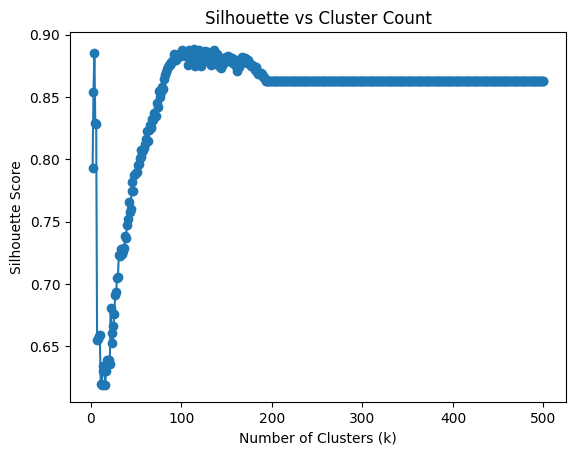

In [19]:
max_clusters = 500           # user-defined

# 1. Select numeric columns from df_train
X = df_train.select_dtypes(include=["number"]).fillna(0.0)

# 2. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Reduce dimensions with PCA (keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4. Define limits for cluster testing
max_allowed = X_pca.shape[0] - 1  # dataset cap
max_k = min(max_clusters, max_allowed)

# 5. Loop through cluster counts and calculate silhouette scores
results = []
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    results.append((k, score))
    #$print(f"k={k}, silhouette={score:.3f}")

# 6. Collect results and plot
scores_df = pd.DataFrame(results, columns=["k", "silhouette"])

plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs Cluster Count")
plt.show()

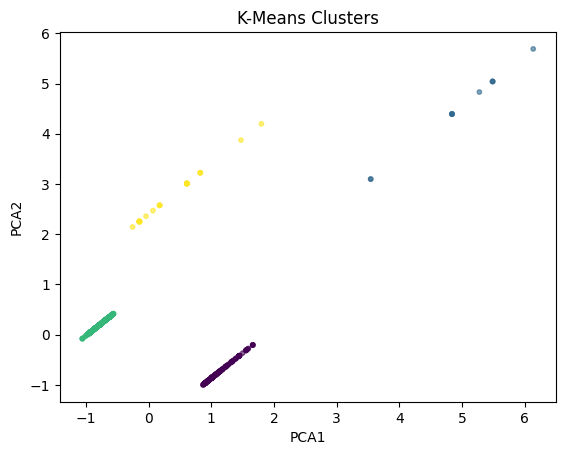

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["cluster"], s=10, alpha=0.6)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("K-Means Clusters")
plt.show()

In [22]:
## scale features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(df_train.select_dtypes(include=['number']))

# cluster
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#labels = dbscan.fit_predict(X_scaled)

#df_train['cluster'] = labels